In [1]:
import JSSP
import time
import numpy as np
import random
import gym
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style
import pandas as pd
import sys


from collections import defaultdict
#import plotting

# Environment Initialization

In [2]:
def create_env(instance_path):
    env_name = "JSSP-v0"
    env = gym.make(env_name, instance_path = instance_path)
    print("Environment Created for: ", instance_path)
    print("Observation space: \n", env.observation_space)
    print("Action space: \n", env.action_space)
    return env

In [16]:
env1 = create_env("instance1.txt") #-53
env3 = create_env("instance3.txt") #-981
env4 = create_env("instance4.txt")
env5 = create_env("instance5.txt")
env5_1 = create_env("instance5_1.txt")

/Users/boyanggu/RL-Research-2022-Summer/JSSP/envs/JSSP_env.py:152: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.observation_space = gym.spaces.Box(low=lower_bound_temp, high=upper_bound_temp, dtype=np.int)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old 

Environment Created for:  instance1.txt
Observation space: 
 Box([-2 -2  0  0], 2, (4,), int64)
Action space: 
 Discrete(8)
Environment Created for:  instance3.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [10 10 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9], (20,), int64)
Action space: 
 Discrete(260)
Environment Created for:  instance4.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], 5, (20,), int64)
Action space: 
 Discrete(756)
Environment Created for:  instance5.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2  0  0  0  0  0  0], 5, (12,), int64)
Action space: 
 Discrete(16)
Environment Created for:  instance5_1.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2  0  0  0  0  0  0], [5 5 5 5 5 5 2 2 2 2 2 2], (12,), int64)
Action space: 
 Discrete(16)


# Baselines

## 1. Random Sampling

In [ ]:
def random_sampling(env, episodes):
    env.reset()
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    for episode in range(1, episodes+1):
        env.reset()
        done = False
        score = 0
        action_list = []
        time_list = []
        while not done:
            #env.render()
            action = env.action_space.sample()
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                # print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            n_state, reward, done, info = env.step(action)
            score+=reward
        # print('Episode:{} Total_reward:{}'.format(episode, score))
        if score >= max_score:
            max_score = score
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
    print('From {}th Episode best policy has reward {}'.format(max_episode, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

## 2. Q-Learning

In [4]:
def get_machine_allocation(state):
    """
    function that returns the machine allocation information at current state
    :param state: current state which is a tuple of order 2 * number of jobs
    :return: a list of order of number of jobs containing the machine allocation information at current state
    """
    state = list(state)
    # machine_allocation = state[:len(state) // 3]
    machine_allocation = state[:len(state) // 2]
    return machine_allocation

In [5]:
def get_operation_status(state):
    """
    function that returns the operation status information at current state
    :param state: current state which is a tuple of order 2 * number of jobs
    :return: a list of order of number of jobs containing the operation status information at current state
    """
    state = list(state)
    # operation_status = state[len(state) // 3:2*len(state) // 3]
    operation_status = state[len(state) // 2:]
    return operation_status

In [6]:
def get_minimum_left_time(job, operation_index, job_operation_map):
    """
    function that returns the minimum time for current job to finish all operations
    It will search through all leftover operations and sum up the minimum
    :param job: job index
    :param operation_index: which operation is this job doing or waiting to do
    :param job_operation_map: the dictionary that covers information about the time each machine will take to finish each operation of each job
    :return: minimum time for this job to finish all leftover operations
    """
    map = job_operation_map[job] # part of the job_operation_map that is related to current job
    minimum_time = 0
    operation_no = sorted(map)[-1]
    if operation_index == operation_no:
        return 1
    for operation in range(int(operation_index), operation_no + 1):
        minimum_time += np.min([time for time in map[operation] if time != -1])
    return minimum_time

In [7]:
def heuristic_makespan(state, env):
    """
    function that returns the minimum time for current state to finish all jobs
    It will search through all jobs and return the maximum of minimum left time of all jobs
    :param state: current state which is a tuple of order 2 * number of jobs
    :param env: JSSP instance
    :return: heuristic minimum time for current state to finish all jobs
    """
    operations = get_operation_status(state)
    minimum_makespan = 0
    for job in range(env.job_total):
        job_minimum_left_time = get_minimum_left_time(job, operations[job], env.job_operation_map)
        # Choose the maximum leftover time
        if job_minimum_left_time > minimum_makespan:
            minimum_makespan = job_minimum_left_time
    return minimum_makespan

In [8]:
def update(Q, state, next_state, action, reward, eta, gamma, env):
    """
    Q-table updating step
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param state: current state which is a tuple of order 2 * number of jobs
    :param next_state: next state which is a tuple of order 2 * number of jobs
    :param action: action between current state and next state
    :param reward: reward for the action
    :param eta: learning rate
    :param gamma: discounted factor
    :param env: JSSP instance
    :return: updated Q table
    """
    machine_allocation = get_machine_allocation(next_state)
    # If Q-table hasn't reached the next state before, using the heuristic function to approximate the maximum Q-value of the next state
    if next_state not in Q:
        Q_next_state_max = -heuristic_makespan(next_state, env)
    else:
        # If all jobs are waiting or done with all operations in the next state, we don't take the Q-value of wait action into consideration
        if jobs_all_waiting(machine_allocation):
            # Make sure the next state is not the done state
            if len(Q[next_state]) > 1:
                Q_next_state_max = max(Q[next_state][:-1])
            else:
                Q_next_state_max = 0
        else:
            Q_next_state_max = max(Q[next_state])

    # Updating step
    Q[state][action] = Q[state][action] + eta * (reward + gamma * Q_next_state_max - Q[state][action])

    return Q

In [9]:
def jobs_all_waiting(machine_allocation):
    """
    function that checks if all jobs are waiting or done with all operations
    :param machine_allocation: list of machine allocation data which using job as index
    :return: boolean value of if all jobs are waiting or done with all operations
    """
    machine_allocation = np.array(machine_allocation)
    # if the job has machine allocation number -1, then it is waiting
    # if the job has machine allocation number -2, then it is done with all operations
    return np.all(np.logical_or(machine_allocation == -1, machine_allocation == -2))

In [10]:
def get_smart_action(state, Q, epsilon, num_actions):
    """
    function that choose action in a smart way
    If all jobs are waiting or done with all operations, then we will not choose the last action(wait action) since it is definitely a bad move.
    :param state: current state which is a tuple of order 2 * number of jobs
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param epsilon: randomness factor, how random the selection is
    :param num_actions: number of actions for the current state
    :return: an index of which action will be chosen
    """
    machine_allocation = get_machine_allocation(state)
    # If the state hasn't been reached yet, choose the action randomly
    if state not in Q:
        action_probabilities = np.ones(num_actions, dtype = float) / num_actions
        return action_probabilities
    else:
        # If in the state all jobs are waiting or done with all operation, choose action based on epsilon-greedy algorithm while making sure we won't choose the wait action at all
        if jobs_all_waiting(machine_allocation):
            best_action = np.argmax(Q[state][:-1])
            action_probabilities = np.ones(num_actions, dtype = float) * epsilon / (num_actions - 1)
            action_probabilities[best_action] += (1.0 - epsilon)
            action_probabilities[-1] = 0
        else:
            best_action = np.argmax(Q[state])
            action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
            action_probabilities[best_action] += (1.0 - epsilon)
    action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
    return action

In [14]:
def q_learning(env, epis, eta = .628, gamma = 1, epsilon = .1):
    """
    q-learning algorithm that returns the best policy, and data for each episode
    :param env: JSSP instance
    :param epis: number of episodes
    :param eta: learning rate, how much you accept the new value vs the old value
    :param gamma: discount factor, balance immediate and future reward
    :param epsilon: randomness factor, how random the selection is
    :return: a list of total reward for each episode, the final Q_table, and a list of total reward every 100 episodes
    """
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []

    # Parameters of Q-learning
    Q_table = {}
    current_epsilon = .1
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = []

    # Q-learning Algorithm
    for episode in range(epis):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        action_list = []
        time_list = []

        # The Q-Table learning algorithm
        while not done:
            if state not in Q_table:
                Q_table[state] = np.negative(np.full(env.action_space.n, heuristic_makespan(state, env), dtype = float))
            action = get_smart_action(state, Q_table, current_epsilon, env.action_space.n)
            # Only record the action in history if it is not a wait action
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                #print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            # Get new state & reward from environment
            next_state, reward, done, _ = env.step(action)
            # Update Q-Table with new knowledge
            Q_table = update(Q_table, state, next_state, action, reward, eta, gamma, env)
            total_reward += reward
            state = next_state
        # Update the final done state
        if state not in Q_table:
            Q_table[state] = np.array([0])
        # Record policy result and store it as policy testing result every 100 episodes
        total_reward_list.append(total_reward)
        if episode % 100 == 0:
            testing_reward_list.append(total_reward)
        # Record the best policy
        if total_reward >= max_score:
            max_score = total_reward
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
        print("Episode: " + str(episode) + " has time " + str(env.time))
        # Set the epsilon to 0 every 1000 episodes
        if episode % 1000 == 0 and episode % 2000 != 0:
            current_epsilon = 0
        if episode % 1000 == 0 and episode % 2000 == 0:
            current_epsilon = epsilon

    print('From {}th Episode best policy has reward {}'.format(max_episode + 1, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

    return total_reward_list, Q_table, testing_reward_list

second version

In [21]:
def get_action(state, Q, epsilon):
    """
    function that choose action in a smart way
    If all jobs are waiting or done with all operations, then we will not choose the last action(wait action) since it is definitely a bad move.
    :param state: current state which is a tuple of order 2 * number of jobs
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param epsilon: randomness factor, how random the selection is
    :param num_actions: number of actions for the current state
    :return: an index of which action will be chosen
    """
    num_actions = len(Q[state])
    # If in the state all jobs are waiting or done with all operation, choose action based on epsilon-greedy algorithm while making sure we won't choose the wait action at all
    best_action = np.argmax(Q[state])
    action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
    action_probabilities[best_action] += (1.0 - epsilon)
    action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
    return action

In [22]:
def update(Q, state, next_state, action, reward, eta, gamma, env):
    """
    Q-table updating step
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param state: current state which is a tuple of order 2 * number of jobs
    :param next_state: next state which is a tuple of order 2 * number of jobs
    :param action: action between current state and next state
    :param reward: reward for the action
    :param eta: learning rate
    :param gamma: discounted factor
    :param env: JSSP instance
    :return: updated Q table
    """
    # If Q-table hasn't reached the next state before, using the heuristic function to approximate the maximum Q-value of the next state
    if next_state not in Q:
        Q_next_state_max = -heuristic_makespan(next_state, env)
    else:
        Q_next_state_max = max(Q[next_state])

    # Updating step
    Q[state][action] += eta * (reward + gamma * Q_next_state_max - Q[state][action])

    return Q

In [23]:
def q_learning(env, epis, eta = .628, gamma = 1, epsilon = .1):
    """
    q-learning algorithm that returns the best policy, and data for each episode
    :param env: JSSP instance
    :param epis: number of episodes
    :param eta: learning rate, how much you accept the new value vs the old value
    :param gamma: discount factor, balance immediate and future reward
    :param epsilon: randomness factor, how random the selection is
    :return: a list of total reward for each episode, the final Q_table, and a list of total reward every 100 episodes
    """
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []

    # Parameters of Q-learning
    Q_table = {}
    current_epsilon = .1
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = []

    # Q-learning Algorithm
    for episode in range(epis):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        action_list = []
        time_list = []

        # The Q-Table learning algorithm
        while not done:
            if state not in Q_table:
                if jobs_all_waiting(env.state[env.job_machine_allocation]):
                    Q_table[state] = np.negative(np.full(env.action_space.n - 1, heuristic_makespan(state, env), dtype = float))
                else:
                    Q_table[state] = np.negative(np.full(env.action_space.n, heuristic_makespan(state, env), dtype = float))
            action = get_action(state, Q_table, current_epsilon)
            # Only record the action in history if it is not a wait action
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                #print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            # Get new state & reward from environment
            next_state, reward, done, _ = env.step(action)
            # Update Q-Table with new knowledge
            Q_table = update(Q_table, state, next_state, action, reward, eta, gamma, env)
            total_reward += reward
            state = next_state
        # Update the final done state
        if state not in Q_table:
            Q_table[state] = np.array([0])
        # Record policy result and store it as policy testing result every 100 episodes
        total_reward_list.append(total_reward)
        if episode % 100 == 0:
            testing_reward_list.append(total_reward)
        # Record the best policy
        if total_reward >= max_score:
            max_score = total_reward
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
        print("Episode: " + str(episode) + " has time " + str(env.time))
        # Set the epsilon to 0 every 1000 episodes
        if episode % 1000 == 0 and episode % 2000 != 0:
            current_epsilon = 0
        if episode % 1000 == 0 and episode % 2000 == 0:
            current_epsilon = epsilon

    print('From {}th Episode best policy has reward {}'.format(max_episode + 1, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

    return total_reward_list, Q_table, testing_reward_list

third version

In [29]:
def q_learning(env, epochs, eta = .628, gamma = 1, epsilon = .1, max_epsilon_greedy_episodes = 1000, max_convergence_episodes = 50000, convergence_guarantee_episodes = 100):
    """
    q-learning algorithm that returns the best policy, and data for each episode
    :param env: JSSP instance
    :param epis: number of episodes
    :param eta: learning rate, how much you accept the new value vs the old value
    :param gamma: discount factor, balance immediate and future reward
    :param epsilon: randomness factor, how random the selection is
    :return: a list of total reward for each episode, the final Q_table, and a list of total reward every 100 episodes
    """
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []

    # Parameters of Q-learning
    Q_table = {}
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = []
    episode_no = 1

    for epoch in range(epochs):
        # Q-learning Algorithm
        current_epsilon = epsilon
        for episode in range(max_epsilon_greedy_episodes):
            # Reset environment
            state = env.reset()
            total_reward = 0
            done = False
            action_list = []
            time_list = []

            # The Q-Table learning algorithm
            while not done:
                if state not in Q_table:
                    if jobs_all_waiting(env.state[env.job_machine_allocation]):
                        Q_table[state] = np.negative(np.full(env.action_space.n - 1, heuristic_makespan(state, env), dtype = float))
                    else:
                        Q_table[state] = np.negative(np.full(env.action_space.n, heuristic_makespan(state, env), dtype = float))
                action = get_action(state, Q_table, current_epsilon)
                # Only record the action in history if it is not a wait action
                if action != env.action_space.n -1:
                    action_list.append(env.legal_allocation_list[action])
                    time_list.append(env.time)
                    #print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
                # Get new state & reward from environment
                next_state, reward, done, _ = env.step(action)
                # Update Q-Table with new knowledge
                Q_table = update(Q_table, state, next_state, action, reward, eta, gamma, env)
                total_reward += reward
                state = next_state
            # Update the final done state
            if state not in Q_table:
                Q_table[state] = np.array([0])
            # Record policy result and store it as policy testing result every 100 episodes
            total_reward_list.append(total_reward)
            episode_no += 1
            if episode % 100 == 0:
                testing_reward_list.append(total_reward)
            # Record the best policy
            if total_reward >= max_score:
                max_score = total_reward
                max_episode = episode
                max_action_list = action_list
                max_time_list = time_list
            print("Episode: " + str(episode) + " has time " + str(env.time))

        current_epsilon = 0
        convergence_no = 1
        for episode in range(max_convergence_episodes):
            # Reset environment
            state = env.reset()
            total_reward = 0
            done = False
            action_list = []
            time_list = []

            # The Q-Table learning algorithm
            while not done:
                if state not in Q_table:
                    if jobs_all_waiting(env.state[env.job_machine_allocation]):
                        Q_table[state] = np.negative(np.full(env.action_space.n - 1, heuristic_makespan(state, env), dtype = float))
                    else:
                        Q_table[state] = np.negative(np.full(env.action_space.n, heuristic_makespan(state, env), dtype = float))
                action = get_action(state, Q_table, current_epsilon)
                # Only record the action in history if it is not a wait action
                if action != env.action_space.n -1:
                    action_list.append(env.legal_allocation_list[action])
                    time_list.append(env.time)
                    #print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
                # Get new state & reward from environment
                next_state, reward, done, _ = env.step(action)
                # Update Q-Table with new knowledge
                Q_table = update(Q_table, state, next_state, action, reward, eta, gamma, env)
                total_reward += reward
                state = next_state
            # Update the final done state
            if state not in Q_table:
                Q_table[state] = np.array([0])
            if total_reward == total_reward_list[-1]:
                convergence_no += 1
            else:
                convergence_no = 1
            # Record policy result and store it as policy testing result every 100 episodes
            total_reward_list.append(total_reward)
            if episode % 100 == 0:
                testing_reward_list.append(total_reward)
            # Record the best policy
            if total_reward >= max_score:
                max_score = total_reward
                max_episode = episode
                max_action_list = action_list
                max_time_list = time_list
            print("Episode: " + str(episode) + " has time " + str(env.time))
            if convergence_no == convergence_guarantee_episodes:
                break

    print('From {}th Episode best policy has reward {}'.format(max_episode + 1, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

    return total_reward_list, Q_table, testing_reward_list

# Analysis

## Random Sampling

In [ ]:
random_sampling(env1, 100)

## QLearning

In [33]:
training_reward_list, Q_table, testing_reward_list = q_learning(env1, 5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  "Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting."
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym 

Episode: 0 has time 65
Episode: 1 has time 69
Episode: 2 has time 60
Episode: 3 has time 60
Episode: 4 has time 66
Episode: 5 has time 68
Episode: 6 has time 72
Episode: 7 has time 65
Episode: 8 has time 60
Episode: 9 has time 61
Episode: 10 has time 61
Episode: 11 has time 66
Episode: 12 has time 63
Episode: 13 has time 67
Episode: 14 has time 66
Episode: 15 has time 61
Episode: 16 has time 60
Episode: 17 has time 59
Episode: 18 has time 60
Episode: 19 has time 59
Episode: 20 has time 63
Episode: 21 has time 61
Episode: 22 has time 65
Episode: 23 has time 61
Episode: 24 has time 61
Episode: 25 has time 65
Episode: 26 has time 65
Episode: 27 has time 58
Episode: 28 has time 68
Episode: 29 has time 59
Episode: 30 has time 60
Episode: 31 has time 60
Episode: 32 has time 60
Episode: 33 has time 59
Episode: 34 has time 60
Episode: 35 has time 61
Episode: 36 has time 59
Episode: 37 has time 65
Episode: 38 has time 60
Episode: 39 has time 59
Episode: 40 has time 61
Episode: 41 has time 62
Ep

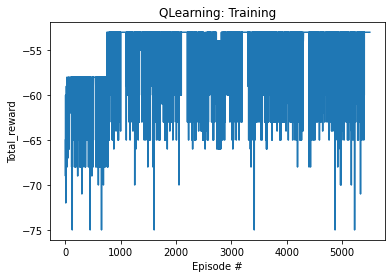

In [34]:
plt.plot(training_reward_list)
plt.title("QLearning: Training")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()

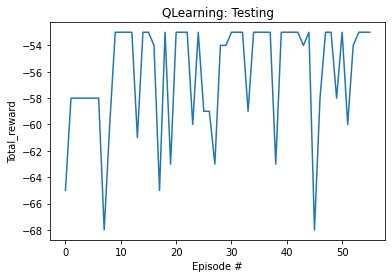

In [35]:
plt.plot(testing_reward_list)
plt.title("QLearning: Testing")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()

In [ ]:
print(Q_table)